In [1]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline 
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
from torch.autograd import Variable
import pickle
device = torch.device(2 if torch.cuda.is_available() else "cpu")

In [2]:
class CnnMusic(nn.Module):
    def __init__(self):
        super(CnnMusic, self).__init__()
        self.conv1 = nn.Conv1d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv1d(32, 128, 3, padding=1)
        self.conv3 = nn.Conv1d(128, 64, 3, padding=1)
        self.conv4 = nn.Conv1d(64, 64, 3, padding=1)
        self.conv5 = nn.Conv1d(64, 64, 3, padding=1)
        self.upsample1 = nn.ConvTranspose1d(64, 64, 3, padding=1, output_padding=1, stride=2)
        self.conv6 = nn.Conv1d(128, 64, 3, padding=1)
        self.upsample2 = nn.ConvTranspose1d(64, 64, 3, padding=1, output_padding=1, stride=2)
        self.conv7 = nn.Conv1d(128, 128, 3, padding=1)
        self.upsample3 = nn.ConvTranspose1d(128, 128, 3, padding=1, output_padding=1, stride=2)
        self.conv8 = nn.Conv1d(256, 32, 3, padding=1)
        self.upsample4 = nn.ConvTranspose1d(32, 32, 3, padding=1, output_padding=1, stride=2)
        self.conv9 = nn.Conv1d(64, 1, 1, padding=0)

    def forward(self, x):
        x=self.conv1(x)
        skip1=x
        x=F.max_pool1d(x, 2)
        x=self.conv2(x)
        skip2=x
        x=F.max_pool1d(x, 2)
        x=self.conv3(x)
        skip3=x
        x=F.max_pool1d(x, 2)
        x=self.conv4(x)
        skip4=x
        x=F.max_pool1d(x, 2)
        x=self.conv5(x)
        x=self.upsample1(x)
        x=torch.cat((x,skip4), dim=1)
        x=self.upsample2(self.conv6(x))
        x=torch.cat((x,skip3), dim=1)
        x=self.upsample3(self.conv7(x))
        x=torch.cat((x,skip2), dim=1)
        x=self.upsample4(self.conv8(x))
        x=torch.cat((x,skip1), dim=1)
        x=self.conv9(x)
        return x

In [3]:
model=CnnMusic()
x=torch.from_numpy(np.random.randn(1,3,512)).float()
print(x.shape)
y=model(x)
print(y.shape)

torch.Size([1, 3, 512])
torch.Size([1, 1, 512])


In [4]:
with open("/home/yiqin/2018summer_project/data/smooth_data_long.pkl", "rb") as f:
    dic = pickle.load(f)
    train_X = dic["X"]
    train_Y = dic["Y"]
print(len(train_X))
print(len(train_Y))

1373
1373


In [5]:
data=[]
for i, x in enumerate(train_X):
    temp=[]
    temp.append(train_X[i])
    temp.append(train_Y[i])
    data.append(temp)
import random
#random.shuffle(data)
print(len(data))
train_data=data[:1300]
val_data=data[1300:]

1373


In [7]:
val_size=len(val_data)
val_x=np.zeros((val_size,3,880))
val_y=np.zeros((val_size,1,880))
val_len=[]
for i in range(val_size):
    val_len.append(len(val_data[i][0]))
    for j in range(len(val_data[i][0])):
        val_x[i][0][j]=val_data[i][0][j][1]-val_data[i][0][j][0]
        val_x[i][1][j]=val_data[i][0][j][2]
        if j!=len(val_data[i][0])-1:
            val_x[i][2][j]=val_data[i][0][j+1][0]-val_data[i][0][j][1]
        val_y[i][0][j]=val_data[i][1][j]
#print(val_x)
#print(val_y)
val_x=Variable(torch.from_numpy(val_x).float().to(device))

In [8]:
def decode(prediction):
    output=[]
    for i in range(val_size):
        temp=[]
        for j in range(val_len[i]):
            if j==0:
                temp.append(0)
                continue
            if prediction[i][0][j]>0.5 and prediction[i][0][j]>prediction[i][0][j+1] and prediction[i][0][j]>prediction[i][0][j-1]:
                temp.append(1)
            else:
                temp.append(0)
        output.append(temp)
    return output

def compute_acc(p, g):
    p=decode(p)
    g=decode(g)
    cor=0
    fal=0
    for i in range(val_size):
        for j in range(val_len[i]):
            if p[i][j]==g[i][j]: cor+=1
            else: fal+=1
    acc=float(cor)/float(cor+fal)
    return acc

In [9]:
def make_batch(index, batch_size):
    s=index*batch_size
    xin=np.zeros((batch_size,3,880))
    yin=np.zeros((batch_size,1,880))
    for i in range(batch_size):
        for j in range(len(train_data[s+i][0])):
            xin[i][0][j]=train_data[s+i][0][j][1]-train_data[s+i][0][j][0]
            xin[i][1][j]=train_data[s+i][0][j][2]
            if j!=len(train_data[s+i][0])-1:
                xin[i][2][j]=train_data[s+i][0][j+1][0]-train_data[s+i][0][j][1]
            yin[i][0][j]=train_data[s+i][1][j]
    return xin, yin

In [10]:
model=CnnMusic()
lr=5e-4
decay=5e-8
optimizer=optim.Adam(model.parameters(),
                     lr=lr,
                     weight_decay=decay)
batch_size=100
epochs=50
loss=0
data_len=len(train_data)
criterion = nn.MSELoss()

In [11]:
def compute_loss(gy,y,ratio):
    temp=gy.cpu().numpy()
    mask=np.ones_like(temp)
    mask[gy>0.99]=ratio
    mask=torch.from_numpy(mask).to(device)
    loss=torch.sub(gy,y)
    loss=torch.mul(loss, loss)
    loss=torch.mul(loss, mask)
    loss=torch.sum(loss)
    loss/=880
    return loss

In [20]:
model=model.to(device)
best_model=None
best_val_acc=0
for i in range(epochs):
    random.shuffle(train_data)
    for j in range(int(data_len/batch_size)):
        input_x, input_y = make_batch(j, batch_size)
        input_x=Variable(torch.from_numpy(input_x).float().to(device))
        input_y=Variable(torch.from_numpy(input_y).float().to(device))
        optimizer.zero_grad()
        output_y=model(input_x)
        loss=compute_loss(input_y, output_y, 137)
        loss.backward()
        optimizer.step()
    print(loss)
    output_val_y=model(val_x)
    val_acc=compute_acc(output_val_y, val_y)
    if val_acc>best_val_acc:
        best_model = torch.save(model.state_dict(), "cnn_best_model.pt")
        best_val_acc = val_acc
    print("current val acc:", val_acc)
    

tensor(9.6788, device='cuda:2')
current val acc: 0.890220749730112
tensor(9.8220, device='cuda:2')
current val acc: 0.890220749730112
tensor(10.6033, device='cuda:2')
current val acc: 0.890220749730112
tensor(16.3351, device='cuda:2')
current val acc: 0.890220749730112
tensor(11.4294, device='cuda:2')
current val acc: 0.890220749730112
tensor(12.4771, device='cuda:2')
current val acc: 0.890220749730112
tensor(7.0606, device='cuda:2')
current val acc: 0.890220749730112
tensor(9.3477, device='cuda:2')
current val acc: 0.890220749730112
tensor(10.4539, device='cuda:2')
current val acc: 0.890220749730112
tensor(10.2254, device='cuda:2')
current val acc: 0.890220749730112
tensor(11.7666, device='cuda:2')
current val acc: 0.890220749730112
tensor(10.6697, device='cuda:2')
current val acc: 0.890220749730112
tensor(12.0567, device='cuda:2')
current val acc: 0.890220749730112
tensor(9.6237, device='cuda:2')
current val acc: 0.890220749730112
tensor(11.8821, device='cuda:2')
current val acc: 0.8

In [21]:
import random
def generate_test(index=1000):
    if index == 1000:
        index=random.randint(0, val_size)
    print(index)
    test_x=np.zeros((1,3,880))
    print(val_x.shape)
    for i in range(val_len[index]):
        test_x[0][0][i]=val_x[index][0][i]
        test_x[0][1][i]=val_x[index][1][i]
        test_x[0][2][i]=val_x[index][2][i]
    test_x=Variable(torch.from_numpy(test_x).float().to(device))
    test_y=model(test_x)
    
    output_y=[]
    gt_y=[]
    for i in range(val_len[index]):
        if i==0:
            output_y.append(0)
            gt_y.append(0)
            continue
        if test_y[0][0][i]>0.5 and test_y[0][0][i]>test_y[0][0][i+1] and test_y[0][0][i]>test_y[0][0][i-1]:
            output_y.append(1)
        else:
            output_y.append(0)
        if val_y[index][0][i]>0.5 and val_y[index][0][i]>val_y[index][0][i+1] and val_y[index][0][i]>val_y[index][0][i-1]:
            gt_y.append(1)
        else:
            gt_y.append(0)
    print(output_y)
    print(gt_y)
    return test_y.detach().reshape(-1).cpu().numpy(), gt_y, output_y
    
print(generate_test())

64
torch.Size([73, 3, 880])
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

In [15]:
model = CnnMusic().to(device)
model.load_state_dict(torch.load("cnn_best_model.pt"))
print(model)

CnnMusic(
  (conv1): Conv1d(3, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (upsample1): ConvTranspose1d(64, 64, kernel_size=(3,), stride=(2,), padding=(1,), output_padding=(1,))
  (conv6): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (upsample2): ConvTranspose1d(64, 64, kernel_size=(3,), stride=(2,), padding=(1,), output_padding=(1,))
  (conv7): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (upsample3): ConvTranspose1d(128, 128, kernel_size=(3,), stride=(2,), padding=(1,), output_padding=(1,))
  (conv8): Conv1d(256, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (upsample4): ConvTranspose1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,), output_padding=(

24
torch.Size([73, 3, 880])
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

<IPython.core.display.Javascript object>


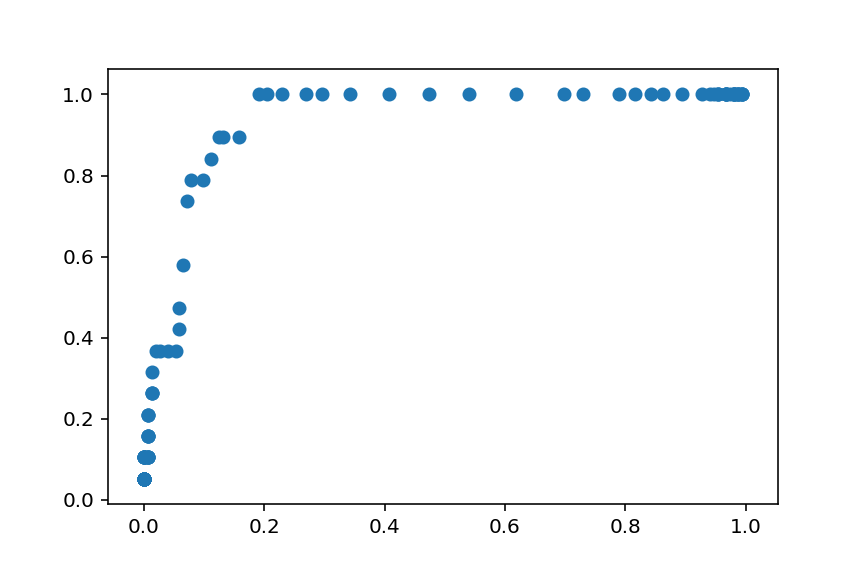

In [23]:
%matplotlib notebook
import matplotlib.pyplot as plt
def AUC(score, truth):
    plot_list = []
    for thre in range(100):
        threshold = thre * 1.0 / 100
        TP = 0
        FN = 0
        FP = 0
        TN = 0
        result = score
        target = np.full_like(result, 1 - threshold)
        result = (np.sign(np.subtract(result, target)) == 1).astype(int)
        for loc, i in enumerate(result):
            if int(truth[loc]) * int(i) == 1:
                TP += 1
            elif int(truth[loc]) == 0 and int(i) == 0:
                TN += 1
            elif int(truth[loc]) == 1 and int(i) == 0:
                FN += 1
            elif int(truth[loc]) == 0 and int(i) == 1:
                FP += 1
        TP_rate = TP * 1.0 / (TP + FN)
        FP_rate = FP * 1.0 / (FP + TN)
        
        plot_list.append((FP_rate, TP_rate))
    return plot_list


def plot_AUC():
    score, gt_y, _ = generate_test()

    result = AUC(score[:len(gt_y)], gt_y)
    xs = [x[0] for x in result]
    ys = [x[1] for x in result]
    plt.scatter(xs, ys)
    plt.show()
    
plot_AUC()

In [19]:
_,_,output_y = generate_test(26)
output = []
output.append(np.array(output_y))
f = open("sample_prediction.pkl", "wb")
pickle.dump(output, f)
f.close()

26
torch.Size([73, 3, 880])
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
print(output_y)
print(val_x.)